In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupKFold
import lightgbm as lgb
import seaborn as sns
import warnings
import os
import math
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

## 1. Loading data

In [0]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
metadata = pd.read_csv('building_metadata.csv')
weather_train = pd.read_csv('weather_train.csv')
weather_test = pd.read_csv('weather_test.csv')

## 2. Plots

### 2.1. Mean meter reading by day and distribution of meter reading

Text(0.5, 0, 'meter reading')

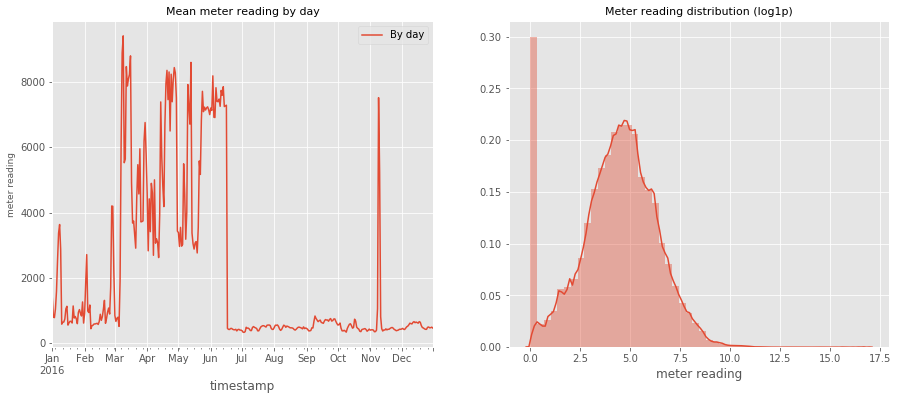

In [3]:
train.timestamp = pd.to_datetime(train.timestamp)
_, axes = plt.subplots(1, 2, figsize=(15, 6))
train[['timestamp', 'meter_reading']] \
                      .set_index('timestamp') \
                      .resample('D') \
                      .mean()['meter_reading'] \
                      .plot(ax=axes[0], label='By day', alpha=1) \
                      .set_ylabel('meter reading', fontsize=9)
sns.distplot(np.log1p(train.meter_reading), ax=axes[1])
axes[0].set_title('Mean meter reading by day', fontsize=11)
axes[0].legend()
axes[1].set_title('Meter reading distribution (log1p)', fontsize=11)
axes[1].set_xlabel('meter reading')

####  As can be seen from the plot, variable distribution is extremely ununiform. Data has a lot of outliers and maybe mistakes

### 2.2. Meter reading by meter type

Text(0.5, 1.0, 'Meter reading bu meter type')

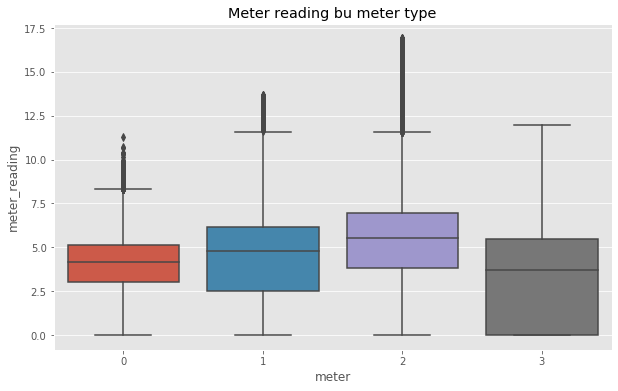

In [4]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=train.meter, y=np.log1p(train.meter_reading))
plt.title('Meter reading by meter type')

In [0]:
# merging datasets
train = train.merge(metadata, on='building_id', how='left')
test = test.merge(metadata, on='building_id', how='left')

### 2.3. Meter reading by site id

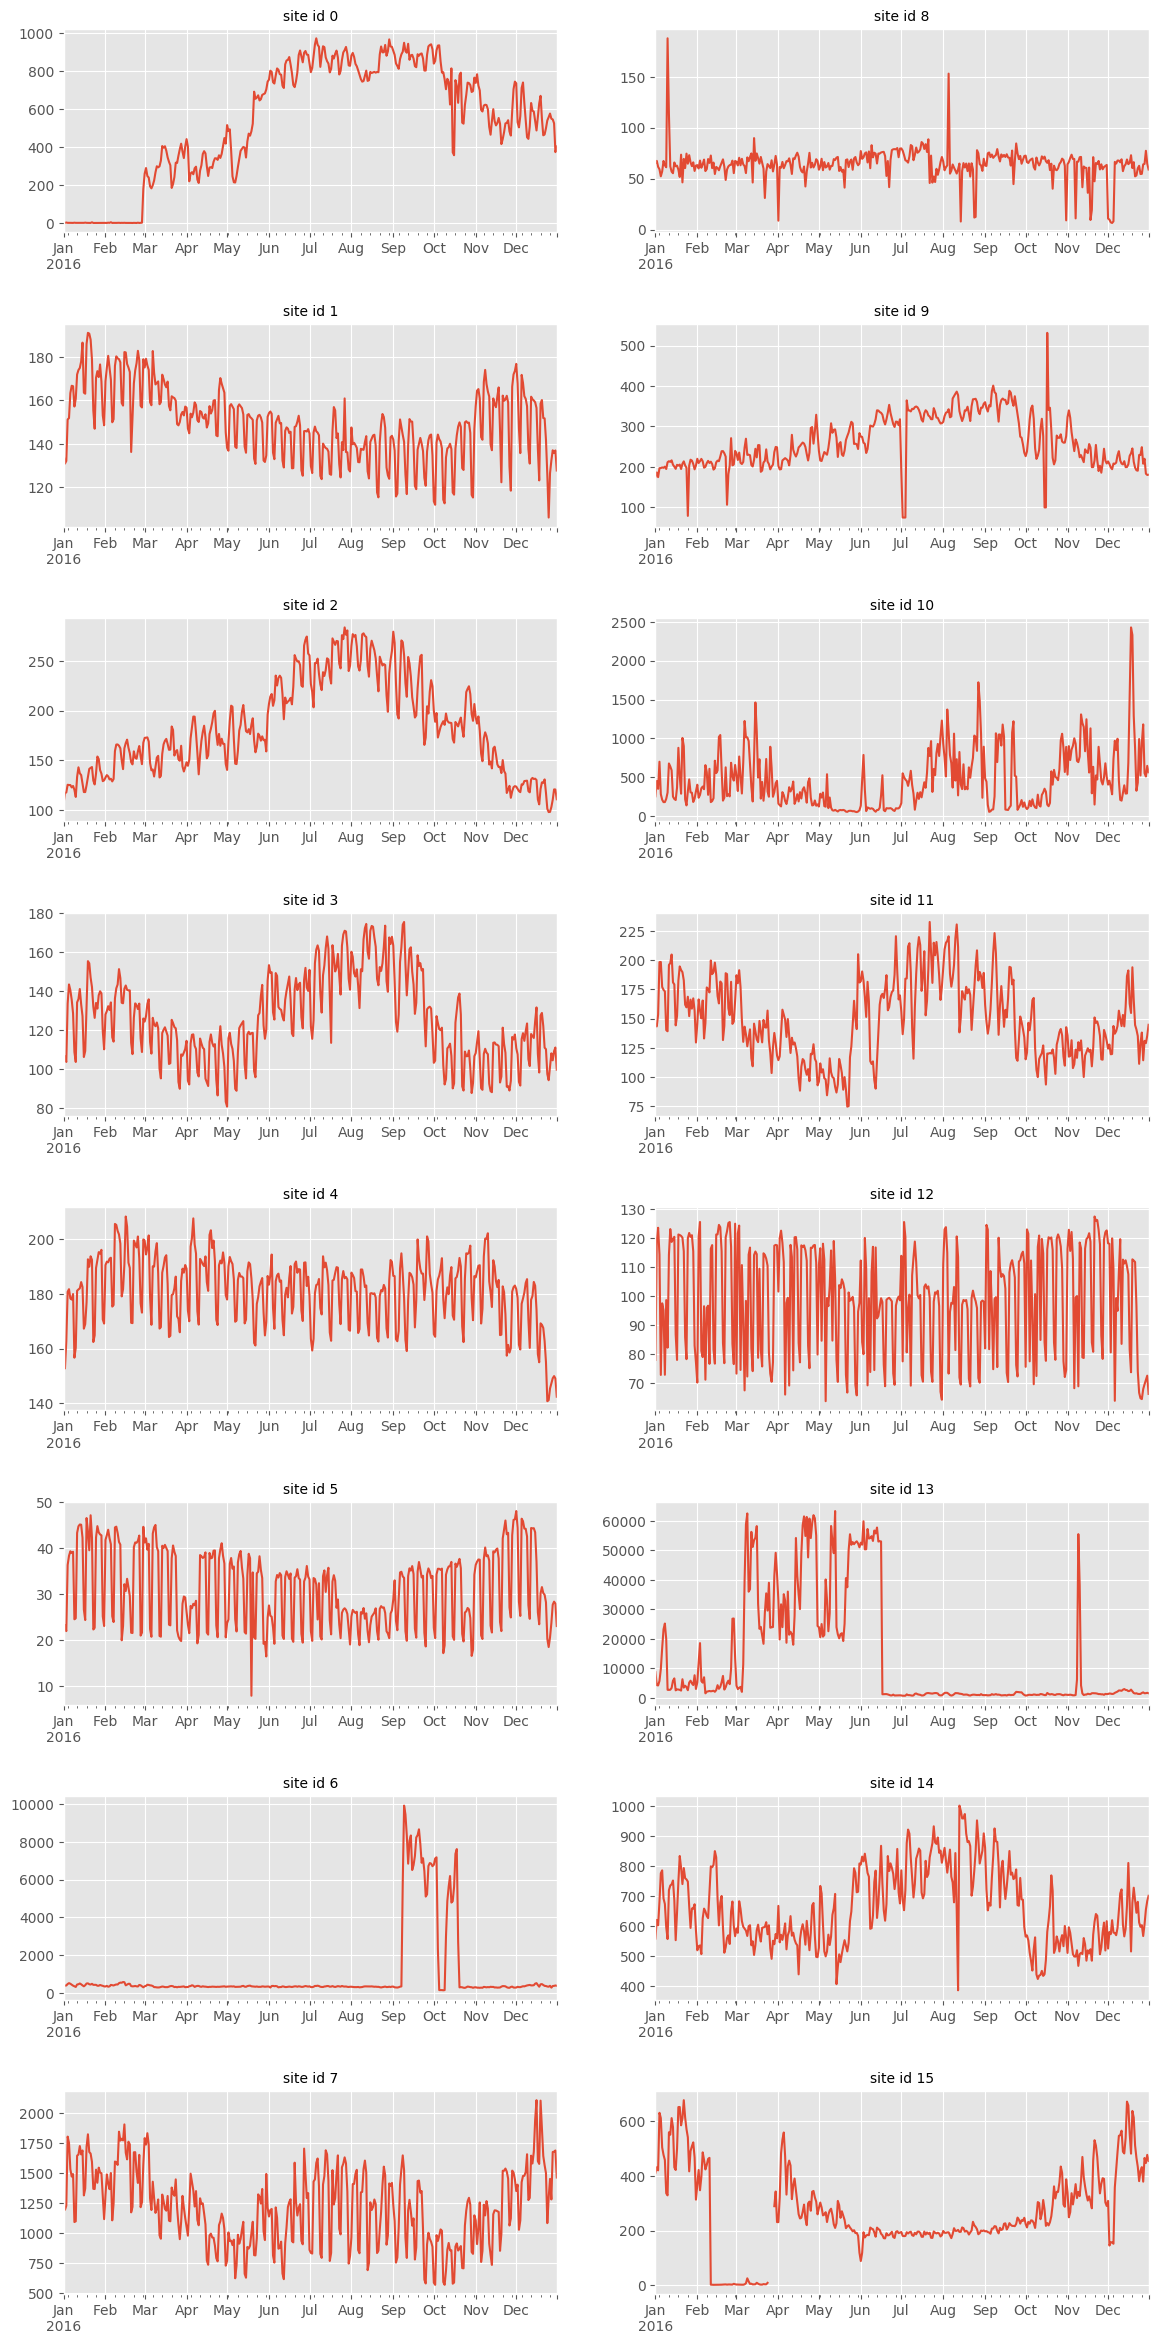

In [6]:
fig, axes = plt.subplots(8, 2, figsize=(14, 30), dpi=100)
for i in range(train['site_id'].nunique()):    
    train[train['site_id'] == i][['timestamp', 'meter_reading']] \
          .set_index('timestamp').resample('D') \
          .mean()['meter_reading'] \
          .plot(ax=axes[i % 8][i // 8], alpha=1, label='By day') \
          .set_xlabel('')    
    axes[i % 8][i // 8].set_title('site id {}'.format(i), fontsize=10)
    plt.subplots_adjust(hspace=0.45)


__What do we see from the data?__
* Site 13 looks like the overall meter reading
* Site 0 srarts from March 2016 (meter 1 starts from March 2016, meter 0 starts from May 2016)





Text(0.5, 1.0, 'Meter reading for site 0 and meter 0')

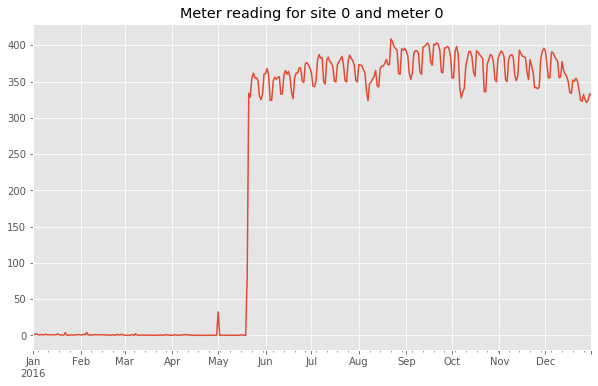

In [7]:
plt.figure(figsize=(10, 6))
train[(train['site_id'] == 0) & (train.meter == 0)][['timestamp', 'meter_reading']] \
          .set_index('timestamp').resample('D') \
          .mean()['meter_reading'] \
          .plot(alpha=1, label='By day') \
          .set_xlabel('')    
plt.title('Meter reading for site 0 and meter 0')


Text(0.5, 1.0, 'Meter reading for site 0 and meter 1')

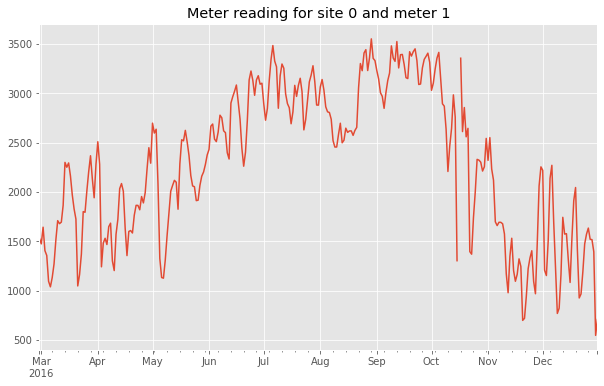

In [8]:
plt.figure(figsize=(10, 6))
train[(train['site_id'] == 0) & (train.meter == 1)][['timestamp', 'meter_reading']] \
          .set_index('timestamp').resample('D') \
          .mean()['meter_reading'] \
          .plot(alpha=1, label='By day') \
          .set_xlabel('')    
plt.title('Meter reading for site 0 and meter 1')

#### Based on data, we can remove observations for site 0 and meter 0 until middle of the May

### 2.4. Meter reading by building id

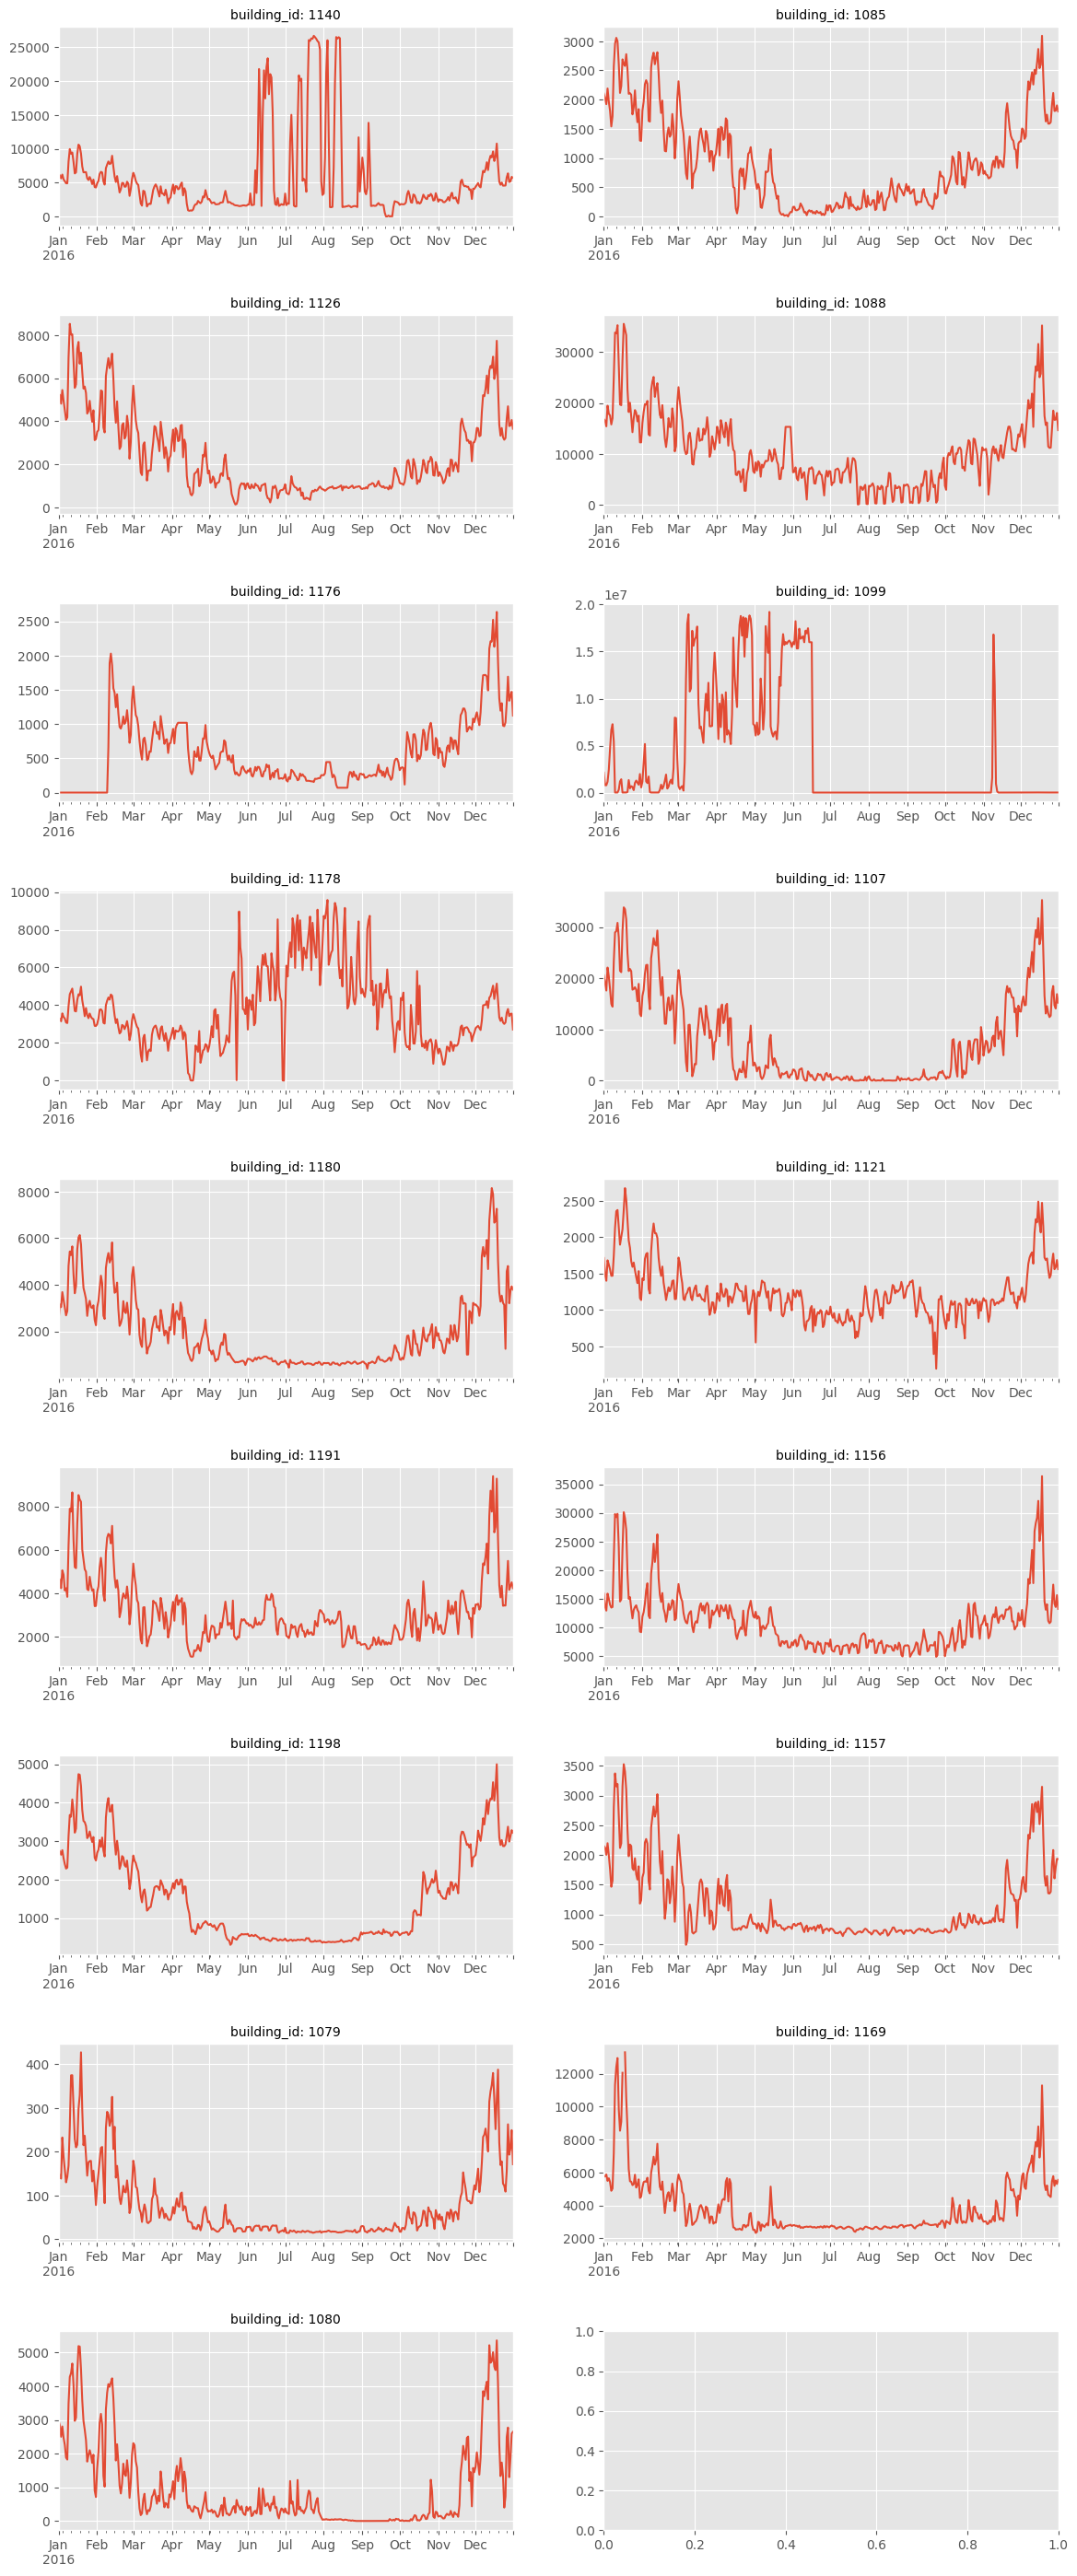

In [9]:
fig, axes = plt.subplots(9, 2, figsize=(14, 36), dpi=100)

for i, building in enumerate(train[(train['site_id'] == 13) 
                    & (train['primary_use'] == 'Education') 
                    & (train['meter'] == 2)]['building_id'] \
                    .value_counts(dropna=False) \
                    .index.to_list()):
    
    
    train[(train['site_id'] == 13) 
      & (train['primary_use'] == 'Education') 
      & (train['meter'] == 2) 
      & (train['building_id'] == building)][['timestamp', 'meter_reading']]\
              .set_index('timestamp')\
              .resample('D').mean()['meter_reading']\
              .plot(ax=axes[i % 9][i // 9], alpha=1, label='By day')\
              .set_xlabel('')    
    axes[i % 9][i // 9].set_title('building_id: ' + str(building), fontsize=10)
    plt.subplots_adjust(hspace=0.45)

 __Building 1099 looks like the overall meter reading. And it is a good idea to exclude this building from data.__

### 2.5. Time features

In [0]:
# add dime features
dates_range = pd.date_range(start='2015-12-31', end='2019-01-01')
us_holidays = calendar().holidays(start=dates_range.min(),       
                                                end=dates_range.max())
train.timestamp = pd.to_datetime(train.timestamp)
train['hour'] = train['timestamp'].dt.hour.astype('category')         
train['weekday'] = train['timestamp'].dt.weekday.astype('category')          
train['is_holiday'] = (train['timestamp'].dt.date.astype('datetime64') \
          .isin(us_holidays)).astype('category')  

Text(0, 0.5, 'meter reading')

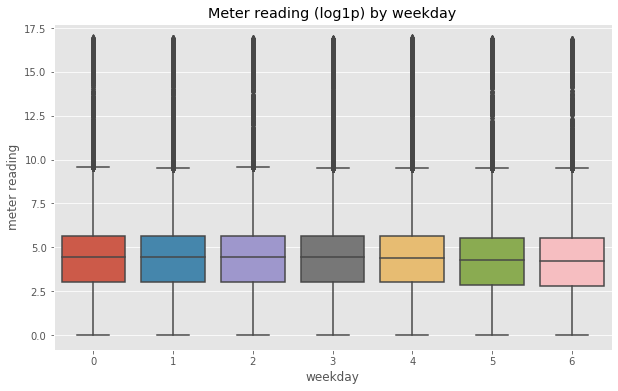

In [11]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=train.weekday, y= np.log1p(train.meter_reading))
plt.title('Meter reading (log1p) by weekday')
plt.ylabel('meter reading')

Text(0, 0.5, 'meter reading')

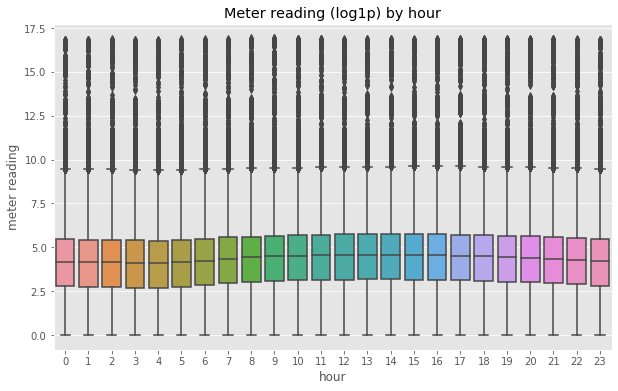

In [12]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=train.hour, y= np.log1p(train.meter_reading))
plt.title('Meter reading (log1p) by hour')
plt.ylabel('meter reading')

Text(0, 0.5, 'meter reading')

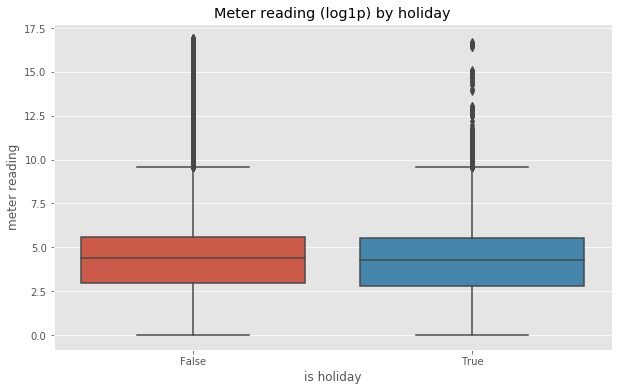

In [13]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=train.is_holiday, y=np.log1p(train.meter_reading))
plt.title('Meter reading (log1p) by holiday')
plt.xlabel('is holiday')
plt.ylabel('meter reading')

__Looks like meter reading depends on time features__

## 3. Preprocessing data  

In [0]:
def fill_na_by_group(col_to_fill, data):    
    for col in col_to_fill:
        data[col] = data.groupby(['month']) \
              [col].transform(lambda x: x.fillna(x.mean()))

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
metadata = pd.read_csv('building_metadata.csv')
weather_train = pd.read_csv('weather_train.csv')
weather_test = pd.read_csv('weather_test.csv')

metadata.year_built.fillna(math.floor(metadata.year_built.median()),
                           inplace=True)
metadata.floor_count.fillna(math.floor(metadata.floor_count.median()),
                           inplace=True)
metadata.square_feet = np.log1p(metadata.square_feet)
le = LabelEncoder()
metadata.primary_use = le.fit_transform(metadata.primary_use)
weather_train['timestamp'] = pd.to_datetime(weather_train['timestamp'])
weather_test['timestamp'] = pd.to_datetime(weather_test['timestamp'])

# fill Nan values
weather_train = weather_train.groupby(['site_id']).apply(lambda x:
                                        x.interpolate(limit_direction='both',
                                             ))
weather_test = weather_test.groupby(['site_id']).apply(lambda x:
                                        x.interpolate(limit_direction='both'))         
for data in [weather_train, weather_test]:    
    data['month'] = data['timestamp'].dt.month.astype(np.int8) 
    col_to_fill = ['air_temperature', 
                   'cloud_coverage',
                   'dew_temperature',
                   'precip_depth_1_hr'
                  ]
    for col in col_to_fill:
        fill_na_by_group([col], data)
    del data['month']  

test.drop(['row_id'], inplace=True, axis=1)
train['timestamp'] = pd.to_datetime(train['timestamp'])
test['timestamp'] = pd.to_datetime(test['timestamp'])
train = train.merge(metadata, how='left', 
                    on='building_id').merge(weather_train, how='left', 
                                            on=['site_id', 'timestamp'])                     
test = test.merge(metadata, how='left', 
                    on='building_id').merge(weather_test, how='left', 
                                            on=['site_id', 'timestamp'])                                       
train.rename(columns={'timestamp': 'date'}, inplace=True)
test.rename(columns={'timestamp': 'date'}, inplace=True)
train.dropna(inplace=True)
for data in [test]:                              
  for col in data.columns.tolist():
      data[col].fillna(method='ffill', inplace=True)      

# remove outliers        
train = \
    train.query('not (building_id <= 104 & meter == 0 & date <= "2016-05-20")')
train = train.loc[train.building_id != 1099]

dates_range = pd.date_range(start='2015-12-31', end='2019-01-01')
us_holidays = calendar().holidays(start=dates_range.min(),       
                                                end=dates_range.max())

# creare time features
for data in [train, test]:
    data['month'] = data['date'].dt.month.astype('category')    
    data['hour'] = data['date'].dt.hour.astype('category')         
    data['weekday'] = data['date'].dt.weekday.astype('category') 
    data.building_id = data.building_id.astype('category')
    data.meter = data.meter.astype('category')
    data.site_id = data.site_id.astype('category')
    data.primary_use = data.primary_use.astype('category')         
    data['is_holiday'] = (data['date'].dt.date.astype('datetime64') \
              .isin(us_holidays)).astype('category')       
    

# create groups for GroupKFold cross validation
groups = train.month.copy()
groups.replace((1, 2, 3, 4, 5, 6), 1, inplace=True)
groups.replace((7, 8, 9, 10, 11, 12), 2, inplace=True)
y = train.meter_reading

## 4. Train model

In [0]:
categoricals = ['building_id', 'meter', 'site_id', 'primary_use', 
                'weekday', 'is_holiday', 'hour']

feature_for_train = [
 'building_id',
 'meter',
 'site_id',
 'primary_use',
 'square_feet',
 'air_temperature',
 'cloud_coverage',
 'dew_temperature',
 'precip_depth_1_hr', 
 'hour',
 'weekday',
 'is_holiday']

lgb_params = {
    "objective": "regression",
    "boosting": "gbdt",
    "num_leaves": 1280,
    "learning_rate": 0.05,
    "feature_fraction": 0.85,
    "reg_lambda": 2,
    "metric": "rmse",
}

models = []
grKFold = GroupKFold(n_splits=2) 
for num_seed in [17, 1, 22, 35, 666]:
  print('seed ', num_seed)
  for train_index, val_index in grKFold.split(train, train['building_id'],
                                                           groups=groups):     
      train_X = train[feature_for_train].iloc[train_index]
      val_X = train[feature_for_train].iloc[val_index]
      train_y = y.iloc[train_index]
      val_y = y.iloc[val_index]     
      
      lgb_train = lgb.Dataset(train_X, np.log1p(train_y), 
                              categorical_feature=categoricals)
      lgb_eval = lgb.Dataset(val_X, np.log1p(val_y), 
                              categorical_feature=categoricals)    
      lgb_params['seed'] = num_seed
      estimator = lgb.train(lgb_params,
                  lgb_train,
                  num_boost_round=2000,
                  valid_sets=(lgb_eval),
                  early_stopping_rounds=100,
                  verbose_eval = 100)        
      models.append(estimator)
best_score = 0
for est in models:
    best_score += est.best_score['valid_0']['rmse']

# average score by all models
print(round(best_score / len(models), 5))  


seed  17
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.14568
Early stopping, best iteration is:
[86]	valid_0's rmse: 1.14477
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.1276
Early stopping, best iteration is:
[69]	valid_0's rmse: 1.12474
seed  1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.14586
Early stopping, best iteration is:
[93]	valid_0's rmse: 1.14569
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.12776
Early stopping, best iteration is:
[69]	valid_0's rmse: 1.12412
seed  22
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.14722
Early stopping, best iteration is:
[96]	valid_0's rmse: 1.14715
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.12834
Early stopping, best iteration is:
[73]	valid_0's rmse: 1.12495
seed  35
Training until validatio